In [1]:
import os
import sys
import traci
from sumolib import checkBinary 
import pandas as pd
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
  tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
  sys.path.append(tools)
else:
  sys.exit("please declare environment variable 'SUMO_HOME'")

In [2]:
useGui = True
logic = 4
yellowTime = 4
maxPercentProportion = 0.5
numCarExpected = 10
num_lane = [3, 4, 2, 2]
edge_name = {0: '-E2', 1: '-E0', 2: '-E1', 3: '-E3'}

standard_time = [61, 71, 45, 50] # north, south, west, east
direction = ['N', 'S', 'W', 'E']
dir_edge = {'N': '-E2', 'S': '-E0', 'W': '-E1', 'E': '-E3'}

In [3]:
def getEdgeHaltingVehicles(edge):
  return traci.edge.getLastStepHaltingNumber(edge)

def getEdgeTotalVehicles(edge):
  return traci.edge.getLastStepVehicleNumber(edge)

def getEdgeWaitingTime(edge):
  return traci.edge.getWaitingTime(edge)

def getEdgeAccumulativeWaitingTime(edge):
  # get all vehicles ID and then get accumulative waiting time for each car ID
  return sum(traci.vehicle.getAccumulatedWaitingTime(vehicle) for vehicle in traci.edge.getLastStepVehicleIDs(edge))

def getCarIdwithDir(carID_dir):
  for i in traci.edge.getLastStepVehicleIDs(dir_edge['N']):
    carID_dir['N'].add(i)
  for i in traci.edge.getLastStepVehicleIDs(dir_edge['S']):
    carID_dir['S'].add(i)
  for i in traci.edge.getLastStepVehicleIDs(dir_edge['W']):
    carID_dir['W'].add(i)
  for i in traci.edge.getLastStepVehicleIDs(dir_edge['E']):
    carID_dir['E'].add(i)

def checkFirstCarArrive():
  return len(traci.edge.getLastStepVehicleIDs('E2')) != 0 or len(traci.edge.getLastStepVehicleIDs('E1')) != 0 \
  or len(traci.edge.getLastStepVehicleIDs('E0')) != 0 or len(traci.edge.getLastStepVehicleIDs('E3')) != 0
 
def totalVehicle(lanes: list):
  numVehicleList = [traci.lane.getLastStepVehicleNumber(lane) for lane in lanes]
  return sum(numVehicleList)

def waiting_time_direction(carID_dir, waiting_time):
  total_time_n = 0;total_time_s = 0
  total_time_w = 0;total_time_e = 0
  for carid in carID_dir['N']:
    total_time_n += waiting_time[carid]
  for carid in carID_dir['S']:
    total_time_s += waiting_time[carid]
  for carid in carID_dir['W']:
    total_time_w += waiting_time[carid]
  for carid in carID_dir['E']:
    total_time_e += waiting_time[carid]

  return total_time_n, total_time_s, total_time_w, total_time_e

def checkLasttCarDepart():
  return len(traci.edge.getLastStepVehicleIDs('-E2')) == 0 and len(traci.edge.getLastStepVehicleIDs('-E1')) == 0 \
  and len(traci.edge.getLastStepVehicleIDs('-E0')) == 0 and len(traci.edge.getLastStepVehicleIDs('-E3')) == 0

In [34]:
net_file = './saint_paul/junction.net.xml'
# route_path = './saint_paul/1.0hour/trips/4000.rou.xml'
route_path = './saint_paul/valid.rou.xml'

carID_dir = {'N': set(), 'S': set(), 'E': set(), 'W': set()}

if(useGui): sumoBinary = checkBinary('sumo-gui')
else: sumoBinary = checkBinary('sumo')
sumoCmd = [sumoBinary, "-n", net_file, "-r", route_path, "--quit-on-end", "--waiting-time-memory", '10000', '--time-to-teleport', '-1']

traci.start(sumoCmd)

trafficLightId = traci.trafficlight.getIDList()[0]
allLanes = list(dict.fromkeys(traci.trafficlight.getControlledLanes(trafficLightId))) # remove duplicate
allPhases = traci.trafficlight.getAllProgramLogics(trafficLightId)[0].phases

switchTime = 0
# current phase = 3 start with N
currentPhase = 3
yellowPhase = True
isArrive = False
carID_dir = {'N': set(), 'S': set(), 'E': set(), 'W': set()}


print('Traffic ', trafficLightId, allPhases)
cars_N = []
time = []
co2 = []
while traci.simulation.getMinExpectedNumber() > 0:
  traci.simulationStep()
  currentTime = traci.simulation.getTime()
  # start when the first car arrive at the junction
  cars_in_N = traci.edge.getLastStepVehicleIDs(dir_edge['N'])
  for c in cars_in_N:
    carID_dir['N'].add(c)
  cars_N.append(len(traci.simulation.getDepartedIDList()))
  time.append(currentTime)
  co2.append(traci.edge.getCO2Emission('-E2'))

  print(currentTime, traci.edge.getCO2Emission('-E2'))  
traci.close()

print(f'Total Car: {len(carID_dir["N"])}')

 Retrying in 1 seconds


Traffic  J0 (Phase(duration=66.0, state='rrrrrrrrGGGGGrrr', minDur=66.0, maxDur=66.0), Phase(duration=5.0, state='rrrrrrrryyyyyrrr', minDur=5.0, maxDur=5.0), Phase(duration=71.0, state='GGGGGrrrrrrrrrrr', minDur=71.0, maxDur=71.0), Phase(duration=5.0, state='yyyyyrrrrrrrrrrr', minDur=5.0, maxDur=5.0), Phase(duration=45.0, state='rrrrrrrrrrrrrGGG', minDur=45.0, maxDur=45.0), Phase(duration=5.0, state='rrrrrrrrrrrrryyy', minDur=5.0, maxDur=5.0), Phase(duration=50.0, state='rrrrrGGGrrrrrrrr', minDur=50.0, maxDur=50.0), Phase(duration=5.0, state='rrrrryyyrrrrrrrr', minDur=5.0, maxDur=5.0))
1.0 2624.722222222222
2.0 3655.344717961397
3.0 5286.803655255669
4.0 6411.160486793724
5.0 10299.065149479971
6.0 12559.067167366613
7.0 10769.85272277312
8.0 9197.739105850807
9.0 14724.427429845455
10.0 11398.989863274415
11.0 14786.354926438566
12.0 14570.701621364604
13.0 12636.2558623365
14.0 11107.67286576785
15.0 22995.022480729032
16.0 23012.421334475202
17.0 24442.155325791577
18.0 15280.255014

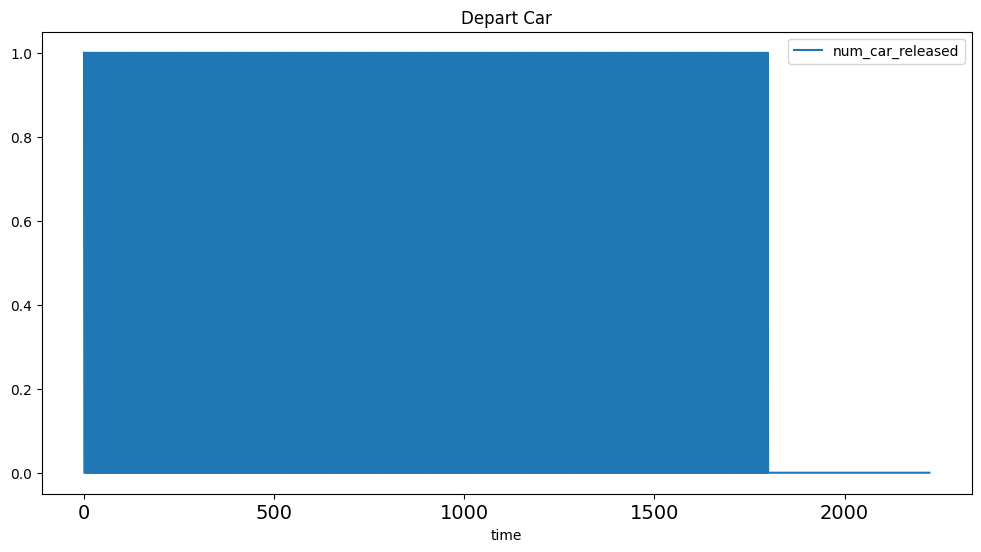

In [31]:
df = pd.DataFrame({'time': time, 'num_car_released': cars_N })
ax = df.plot(kind='line', 
        title='Depart Car', x='time', y='num_car_released', figsize=(12, 6))

ax.tick_params(axis = 'x' , labelsize = 14 )

<BarContainer object of 2223 artists>

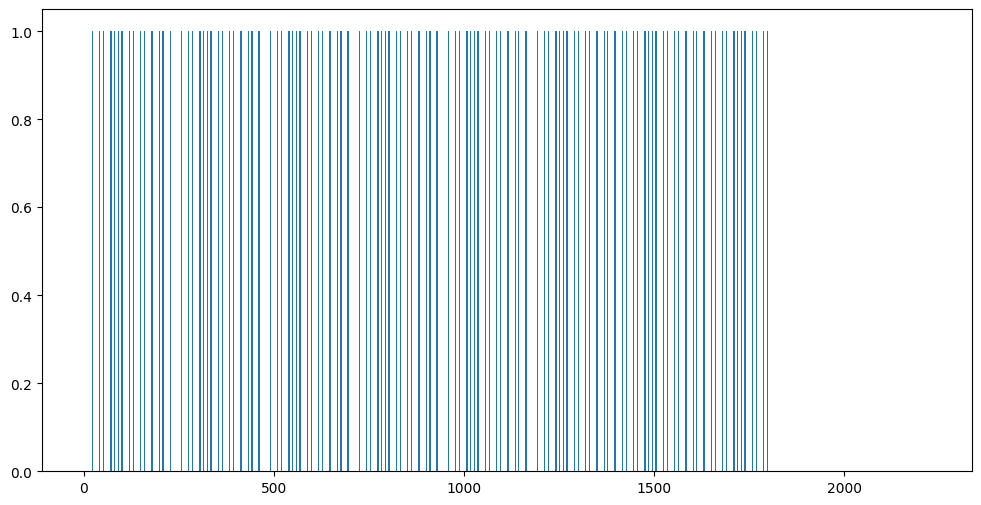

In [32]:
plt.figure(figsize=(12,6))
plt.bar(time, cars_N)

In [33]:
df = pd.DataFrame({'time': time, 'num_car_released': cars_N })
df = df.astype({"time": int})
df

,time,num_car_released
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
2218,2219,0
2219,2220,0
2220,2221,0
2221,2222,0


<BarContainer object of 2223 artists>

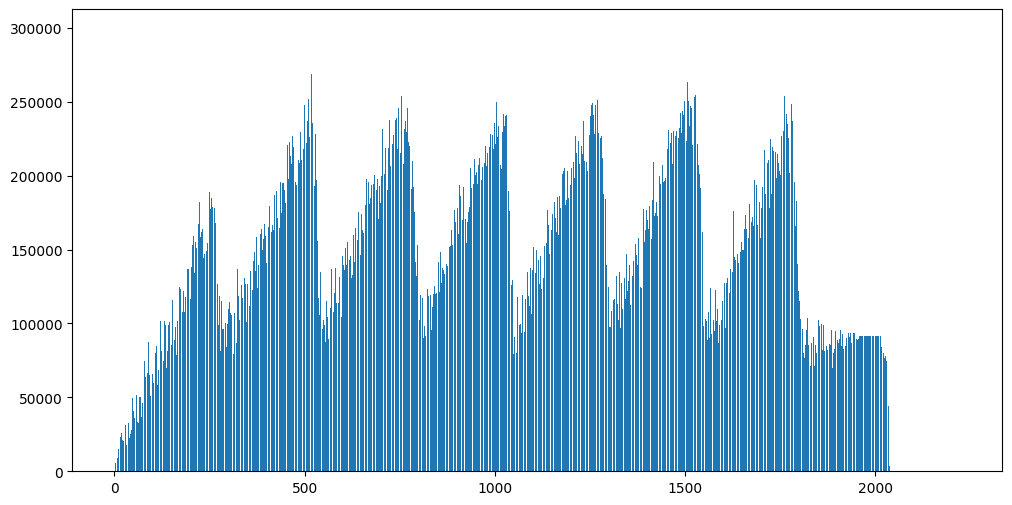

In [35]:
plt.figure(figsize=(12,6))
plt.bar(time, co2)

In [25]:
useGui = False
net_file = './saint_paul/junction.net.xml'
# route_path = './saint_paul/1.0hour/trips/4000.rou.xml'
route_path = './saint_paul/valid.rou.xml'

carID_dir = {'N': set(), 'S': set(), 'E': set(), 'W': set()}

if(useGui): sumoBinary = checkBinary('sumo-gui')
else: sumoBinary = checkBinary('sumo')
sumoCmd = [sumoBinary, "-n", net_file, "-r", route_path, "--quit-on-end", "--waiting-time-memory", '10000', '--time-to-teleport', '-1']

traci.start(sumoCmd)

trafficLightId = traci.trafficlight.getIDList()[0]
allLanes = list(dict.fromkeys(traci.trafficlight.getControlledLanes(trafficLightId))) # remove duplicate
allPhases = traci.trafficlight.getAllProgramLogics(trafficLightId)[0].phases

switchTime = 0
# current phase = 3 start with N
currentPhase = 3
yellowPhase = True
isArrive = False
carID_dir = {'N': set(), 'S': set(), 'E': set(), 'W': set()}
open_green = 30
# dir_edge = {'N': '-E2', 'S': '-E0', 'W': '-E1', 'E': '-E3'}

print('Traffic ', trafficLightId, allPhases)
cars_N = []
time = []
co2 = []
while traci.simulation.getMinExpectedNumber() > 0:
  traci.simulationStep()
  currentTime = traci.simulation.getTime()
  # start when the first car arrive at the junction
  cars_in_N = traci.edge.getLastStepVehicleIDs(dir_edge['E'])
  for c in cars_in_N:
    carID_dir['E'].add(c)
  cars_N.append(len(traci.simulation.getDepartedIDList()))
  time.append(currentTime)
  co2.append(traci.edge.getCO2Emission('-E3'))
  if currentTime < 2000:
    traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[0].state)
  elif currentTime < 2000 + open_green:
    traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[6].state)
    print(traci.lane.getLastStepVehicleNumber('-E3_0'),traci.lane.getLastStepVehicleNumber('-E3_1'))
    # print(traci.edge.getLastStepVehicleNumber('-E0'), traci.edge.getLastStepLength('-E0'))
  elif currentTime < 2000 + open_green + 4:
    traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[7].state)
  else:
    traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[0].state)

    # print(traci.simulation.getArrivedNumber())
  if currentTime > 2200: break
  if len(traci.edge.getLastStepVehicleIDs('-E3')) == 0: break

traci.close()

print(f'Total Car: {len(carID_dir["N"])}')

 Retrying in 1 seconds


Traffic  J0 (Phase(duration=66.0, state='rrrrrrrrGGGGGrrr', minDur=66.0, maxDur=66.0), Phase(duration=5.0, state='rrrrrrrryyyyyrrr', minDur=5.0, maxDur=5.0), Phase(duration=71.0, state='GGGGGrrrrrrrrrrr', minDur=71.0, maxDur=71.0), Phase(duration=5.0, state='yyyyyrrrrrrrrrrr', minDur=5.0, maxDur=5.0), Phase(duration=45.0, state='rrrrrrrrrrrrrGGG', minDur=45.0, maxDur=45.0), Phase(duration=5.0, state='rrrrrrrrrrrrryyy', minDur=5.0, maxDur=5.0), Phase(duration=50.0, state='rrrrrGGGrrrrrrrr', minDur=50.0, maxDur=50.0), Phase(duration=5.0, state='rrrrryyyrrrrrrrr', minDur=5.0, maxDur=5.0))
135 135
134 134
134 134
134 134
133 133
133 133
133 133
132 132
132 132
132 131
131 131
131 130
130 130
130 129
130 129
129 128
129 128
128 127
128 127
128 126
127 126
127 126
126 125
126 125000.00 (1ms ~= 1000.00*RT, ~270000.00UPS, TraCI: 1ms, vehicles TOT 270 ACT 270 BUF 
125 124
125 124
125 124
125 124
124 123
124 123
Step #2201.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 270 ACT 250 BUF 0)          